In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Conv1D, MaxPooling1D, 
                                   Embedding, Dropout, BatchNormalization, 
                                   GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_data(df):
    """Preprocess data with validation checks"""
    # Verify sequences
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    # Extract features
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    # Generate k-mers
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    
    # Prepare sequence data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    # Verify data
    assert not np.isnan(X_seq).any(), "NaN values in sequence data"
    assert not np.isnan(X_num).any(), "NaN values in numerical features"
    
    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Number of classes: {len(np.unique(y))}")
    print(f"Feature shape: {X_num.shape}")
    print(f"Sequence shape: {X_seq.shape}")
    
    return X_seq, X_num, y, tokenizer, scaler, label_encoder

def build_model(vocab_size, n_features, n_classes):
    """Build model with adjusted architecture"""
    # Sequence input
    seq_input = Input(shape=(500,))
    x1 = Embedding(vocab_size + 1, 64)(seq_input)
    
    # CNN branch
    conv1 = Conv1D(32, 3, activation='relu', padding='same')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(2)(conv1)
    
    conv2 = Conv1D(16, 3, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = GlobalMaxPooling1D()(conv2)
    
    # LSTM branch
    lstm = LSTM(32, return_sequences=False)(x1)
    lstm = BatchNormalization()(lstm)
    
    # Combine sequence features
    seq_features = Concatenate()([conv2, lstm])
    seq_features = Dropout(0.2)(seq_features)
    
    # Numerical features
    num_input = Input(shape=(n_features,))
    num_features = Dense(16, activation='relu')(num_input)
    num_features = BatchNormalization()(num_features)
    
    # Combine all features
    combined = Concatenate()([seq_features, num_features])
    
    # Dense layers
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=[seq_input, num_input], outputs=outputs)
    return model

def train_model():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = pd.read_csv('/kaggle/input/moomoo/momo.csv')
    X_seq, X_num, y, tokenizer, scaler, label_encoder = preprocess_data(df)
    
    # K-fold settings
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []
    histories = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_seq)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        
        # Split data
        X_seq_train, X_seq_val = X_seq[train_idx], X_seq[val_idx]
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Build and compile model
        model = build_model(
            vocab_size=len(tokenizer.word_index),
            n_features=X_num.shape[1],
            n_classes=len(np.unique(y))
        )
        
        model.compile(
            optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Print model summary for first fold
        if fold == 0:
            model.summary()
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',  # Changed to monitor accuracy
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_accuracy',  # Changed to monitor accuracy
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        # Train
        history = model.fit(
            [X_seq_train, X_num_train],
            y_train,
            validation_data=([X_seq_val, X_num_val], y_val),
            epochs=100,
            batch_size=64,  # Increased batch size
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        scores = model.evaluate([X_seq_val, X_num_val], y_val, verbose=1)
        fold_scores.append(scores[1])
        histories.append(history.history)
        
        # Save fold model
        model.save(f'model_fold_{fold+1}.h5')
        
        # Clear session
        tf.keras.backend.clear_session()
    
    # Print results
    print("\nCross Validation Results:")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"\nMean Accuracy: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")
    
    # Save preprocessing objects
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

if __name__ == "__main__":
    train_model()

Loading and preprocessing data...


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/moomoo/momo.csv'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

def preprocess_data(df):
    """Preprocess data with validation checks"""
    # Verify sequences
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    # Extract features
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    # Generate k-mers
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    
    # Prepare sequence data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    # Combine features
    X = np.hstack((X_seq, X_num))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    return X, y

def compare_models():
    # Load data
    print("Loading and preprocessing data...")
    df = pd.read_csv('/kaggle/input/moomoo/momo.csv')
    X, y = preprocess_data(df)
    
    # Initialize models with parameters to prevent overfitting
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, max_depth=10, min_samples_split=5, 
            min_samples_leaf=2, random_state=42
        ),
        'SVM': SVC(
            kernel='rbf', C=1.0, gamma='scale', random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(64, 32), max_iter=300, early_stopping=True,
            validation_fraction=0.1, random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=5,
            min_samples_split=5, random_state=42
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100, max_depth=5, learning_rate=0.1,
            min_child_weight=2, gamma=0.1, random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=5, weights='distance'
        )
    }
    
    # K-fold settings
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store results
    results = {model_name: [] for model_name in models.keys()}
    
    # Train and evaluate models
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        for model_name, model in models.items():
            print(f"Training {model_name}...")
            model.fit(X_train, y_train)
            val_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, val_pred)
            results[model_name].append(accuracy)
            print(f"{model_name} Fold {fold + 1} Accuracy: {accuracy:.4f}")
    
    # Calculate and display final results
    print("\nFinal Results:")
    mean_scores = {}
    std_scores = {}
    
    for model_name, scores in results.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        mean_scores[model_name] = mean_score
        std_scores[model_name] = std_score
        print(f"{model_name}:")
        print(f"Mean Accuracy: {mean_score:.4f} (±{std_score:.4f})")
        print(f"Individual Fold Scores: {', '.join([f'{score:.4f}' for score in scores])}\n")
    
    # Plotting results
    plt.figure(figsize=(12, 6))
    models_list = list(mean_scores.keys())
    means = list(mean_scores.values())
    stds = list(std_scores.values())
    
    bars = plt.bar(models_list, means, yerr=stds, capsize=5)
    plt.title('Model Comparison - 5-Fold Cross Validation')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_models()

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf

# Loop through the saved models for each fold
n_folds = 5  # Adjust based on your setup
for fold in range(1, n_folds + 1):
    print(f"\nEvaluating metrics for Fold {fold}")
    
    # Load the model
    model = tf.keras.models.load_model(f'model_fold_{fold}.h5')
    
    # Predict on the validation set (you need to ensure `X_seq_val` and `X_num_val` are accessible)
    val_predictions = model.predict([X_seq_val, X_num_val])
    val_predictions = np.argmax(val_predictions, axis=1)  # Get the class with the highest probability
    
    # Generate confusion matrix
    cm = confusion_matrix(y_val, val_predictions)
    
    # Calculate TP, FP, FN, TN
    tp = np.diag(cm)  # True Positives for each class
    fp = cm.sum(axis=0) - tp  # False Positives
    fn = cm.sum(axis=1) - tp  # False Negatives
    tn = cm.sum() - (fp + fn + tp)  # True Negatives
    
    # Print metrics for this fold
    print("Confusion Matrix:")
    print(cm)
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Negatives: {tn}")



Evaluating metrics for Fold 1


NameError: name 'X_seq_val' is not defined

In [9]:
# Save validation data for each fold
np.save(f'X_seq_val_fold_{fold+1}.npy', X_seq_val)
np.save(f'X_num_val_fold_{fold+1}.npy', X_num_val)
np.save(f'y_val_fold_{fold+1}.npy', y_val)


NameError: name 'X_seq_val' is not defined

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

# Preprocess data
def preprocess_data(df):
    """Preprocess data for model input."""
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    # Extract features
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    # Generate k-mers
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    
    # Prepare sequence data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    return X_seq, X_num, y, tokenizer, scaler, label_encoder

# Load saved preprocessing objects
def load_preprocessing_objects():
    with open('tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    return tokenizer, scaler, label_encoder

# Evaluate specific fold
def evaluate_fold(fold_number, model_path, df_path):
    # Load and preprocess data
    print("Loading data...")
    df = pd.read_csv(df_path)
    X_seq, X_num, y, tokenizer, scaler, label_encoder = preprocess_data(df)
    
    # K-Fold setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold = 0

    for train_idx, val_idx in kf.split(X_seq):
        fold += 1
        if fold == fold_number:
            # Split the data for the specific fold
            X_seq_val = X_seq[val_idx]
            X_num_val = X_num[val_idx]
            y_val = y[val_idx]
            
            # Load the model for this fold
            print(f"Loading model for fold {fold}...")
            model = load_model(model_path)
            
            # Evaluate
            print("Evaluating...")
            val_predictions = model.predict([X_seq_val, X_num_val])
            val_predictions = np.argmax(val_predictions, axis=1)
            
            # Calculate metrics
            from sklearn.metrics import confusion_matrix, classification_report
            cm = confusion_matrix(y_val, val_predictions)
            report = classification_report(y_val, val_predictions)
            
            print("Confusion Matrix:")
            print(cm)
            print("\nClassification Report:")
            print(report)
            break

# Main function
if __name__ == "__main__":
    FOLD_NUMBER = 1  # Specify the fold to evaluate
    MODEL_PATH = f'/kaggle/working/model_fold_{FOLD_NUMBER}.h5'  # Path to the saved model for the specific fold
    DF_PATH = '/kaggle/input/moomoo/momo.csv'  # Path to your dataset
    
    evaluate_fold(FOLD_NUMBER, MODEL_PATH, DF_PATH)


Loading data...
Loading model for fold 1...
Evaluating...
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Confusion Matrix:
[[492   0   0   0   0   0   0   0   0   0   1   0   0   1   0   1   0]
 [  0 121   1   0   0   0   0   0   0   1   0   0   1   0   0   1   0]
 [  0   0 303   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0 436   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0 323   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   2 217   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 113   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  88   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   2 156   0   0   0   1   0   0   0   0]
 [  0   1   0   0   1   0   0   0   0 231   4   1   0   0   0   2   0]
 [  1   0   0   0   0   1   0   0   0   4 305   0   0   0   0   0   0]
 [  0   2   1   0   0   0   0   0   0   1   2 391   0   0   0  19   0]
 [  4   1   0   0   0   2   1  

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_16336\2748054855.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))


Training Fold 1
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 49s 147ms/step - accuracy: 0.3008 - loss: 2.4382 - val_accuracy: 0.3383 - val_loss: 2.2492 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - accuracy: 0.6863 - loss: 1.0929 - val_accuracy: 0.4803 - val_loss: 1.9885 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.7966 - loss: 0.6953 - val_accuracy: 0.7585 - val_loss: 0.7432 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8432 - loss: 0.5200 - val_accuracy: 0.8520 - val_loss: 0.4836 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.8738 - loss: 0.4283 - val_accuracy: 0.6829 - val_loss: 0.9134 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8968 - loss: 0.3525 - val_accuracy: 0.8553 - val_loss: 0.5020 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━

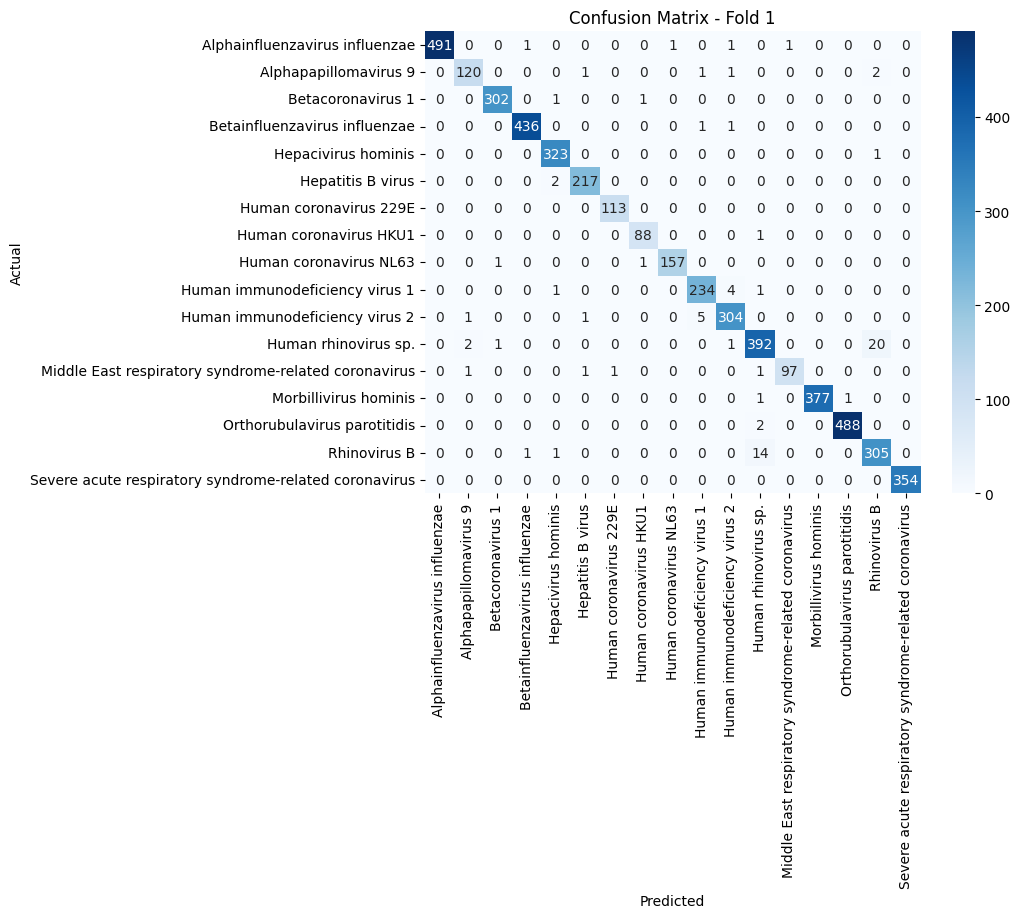

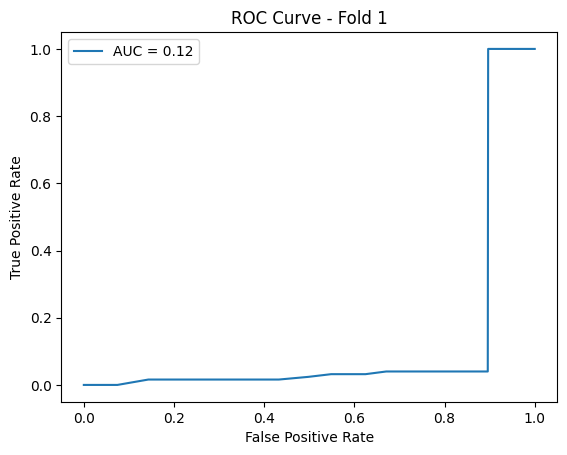

ValueError: multiclass format is not supported

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, accuracy_score)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D, LSTM, 
                                     Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Data Preprocessing
def preprocess_data(df):
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    
    return X_seq, X_num, y, tokenizer, scaler, label_encoder

# Model Definition
def build_model(vocab_size, n_features, n_classes):
    seq_input = Input(shape=(500,))
    x1 = Embedding(vocab_size + 1, 64)(seq_input)
    conv1 = Conv1D(32, 3, activation='relu', padding='same')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(16, 3, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = GlobalMaxPooling1D()(conv2)
    lstm = LSTM(32, return_sequences=False)(x1)
    lstm = BatchNormalization()(lstm)
    seq_features = Concatenate()([conv2, lstm])
    seq_features = Dropout(0.2)(seq_features)
    num_input = Input(shape=(n_features,))
    num_features = Dense(16, activation='relu')(num_input)
    num_features = BatchNormalization()(num_features)
    combined = Concatenate()([seq_features, num_features])
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs=[seq_input, num_input], outputs=outputs)

# Training and Evaluation
def train_and_evaluate():
    df = pd.read_csv('momo.csv')  # Update with your dataset path
    X_seq, X_num, y, tokenizer, scaler, label_encoder = preprocess_data(df)
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []
    histories = []
    class_names = label_encoder.classes_
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_seq)):
        print(f"Training Fold {fold + 1}")
        X_seq_train, X_seq_val = X_seq[train_idx], X_seq[val_idx]
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = build_model(len(tokenizer.word_index), X_num.shape[1], len(np.unique(y)))
        model.compile(optimizer=Adam(learning_rate=0.0005),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        history = model.fit(
            [X_seq_train, X_num_train], y_train,
            validation_data=([X_seq_val, X_num_val], y_val),
            epochs=100, batch_size=64, callbacks=callbacks, verbose=1
        )
        histories.append(history.history)
        fold_scores.append(model.evaluate([X_seq_val, X_num_val], y_val, verbose=1)[1])
        
        # Confusion Matrix
        y_pred = np.argmax(model.predict([X_seq_val, X_num_val]), axis=1)
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_val, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold + 1}')
        plt.legend()
        plt.show()
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Fold {fold + 1}')
        plt.legend()
        plt.show()
        
        tf.keras.backend.clear_session()
    
    # Training Curves
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss - Fold {i + 1}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Training vs Validation Accuracy - Fold {i + 1}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    print(f"Mean Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

if __name__ == "__main__":
    train_and_evaluate()


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_1820\960630589.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))


Training Fold 1
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.3537 - loss: 2.2614 - val_accuracy: 0.2628 - val_loss: 2.4480 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.7119 - loss: 0.9983 - val_accuracy: 0.7847 - val_loss: 0.7647 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.8153 - loss: 0.6273 - val_accuracy: 0.8780 - val_loss: 0.4322 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.8576 - loss: 0.4753 - val_accuracy: 0.8631 - val_loss: 0.4550 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.8824 - loss: 0.3869 - val_accuracy: 0.9237 - val_loss: 0.2610 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.9014 - loss: 0.3247 - val_accuracy: 0.9116 - val_loss: 0.2678 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━━━━━━━

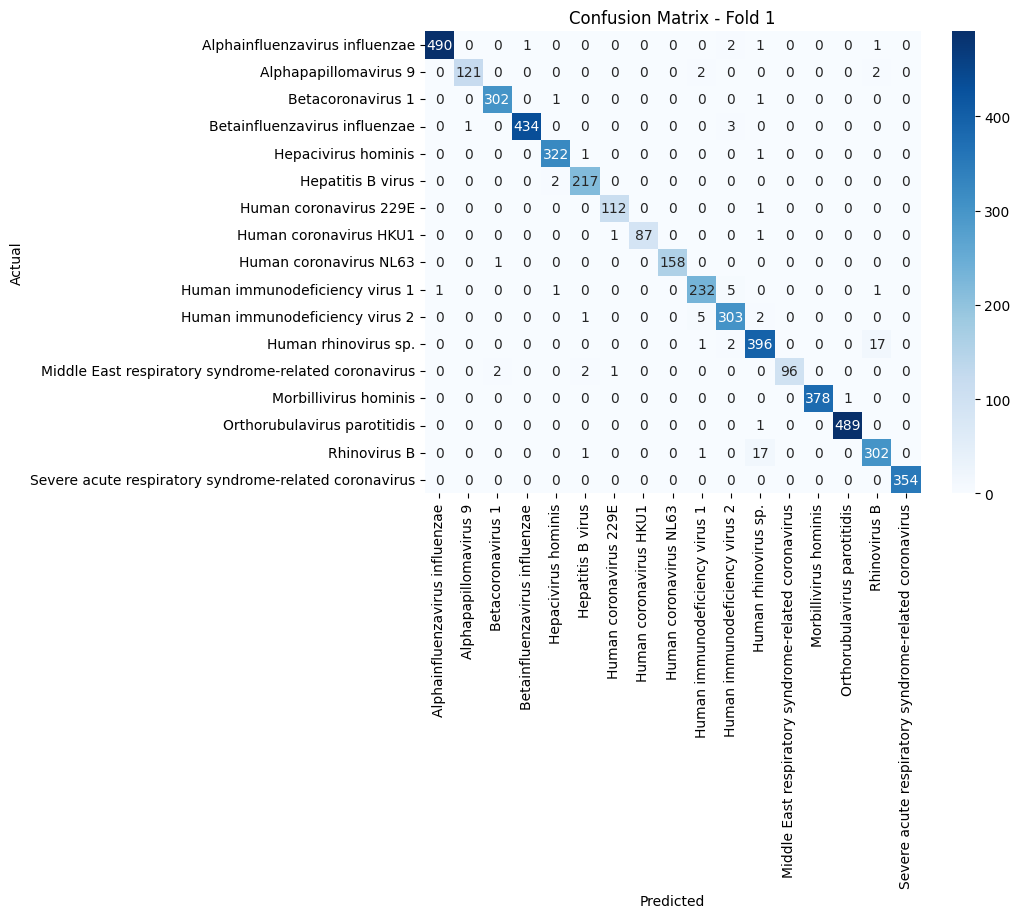

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


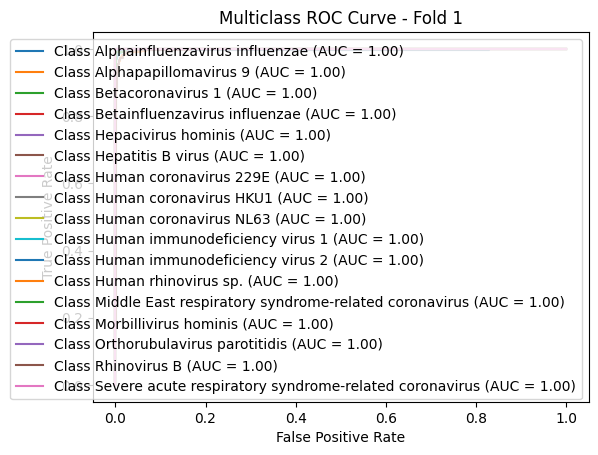

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


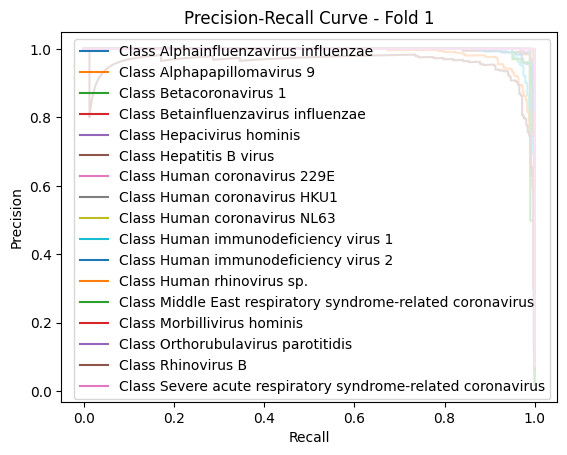


Training Fold 2
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - accuracy: 0.2770 - loss: 2.4547 - val_accuracy: 0.1909 - val_loss: 3.1065 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.6805 - loss: 1.1476 - val_accuracy: 0.5244 - val_loss: 1.4667 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.7999 - loss: 0.7185 - val_accuracy: 0.7245 - val_loss: 0.9166 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.8367 - loss: 0.5650 - val_accuracy: 0.8680 - val_loss: 0.4538 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.8734 - loss: 0.4326 - val_accuracy: 0.8624 - val_loss: 0.4537 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.8910 - loss: 0.3780 - val_accuracy: 0.9299 - val_loss: 0.2429 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━━━━━━

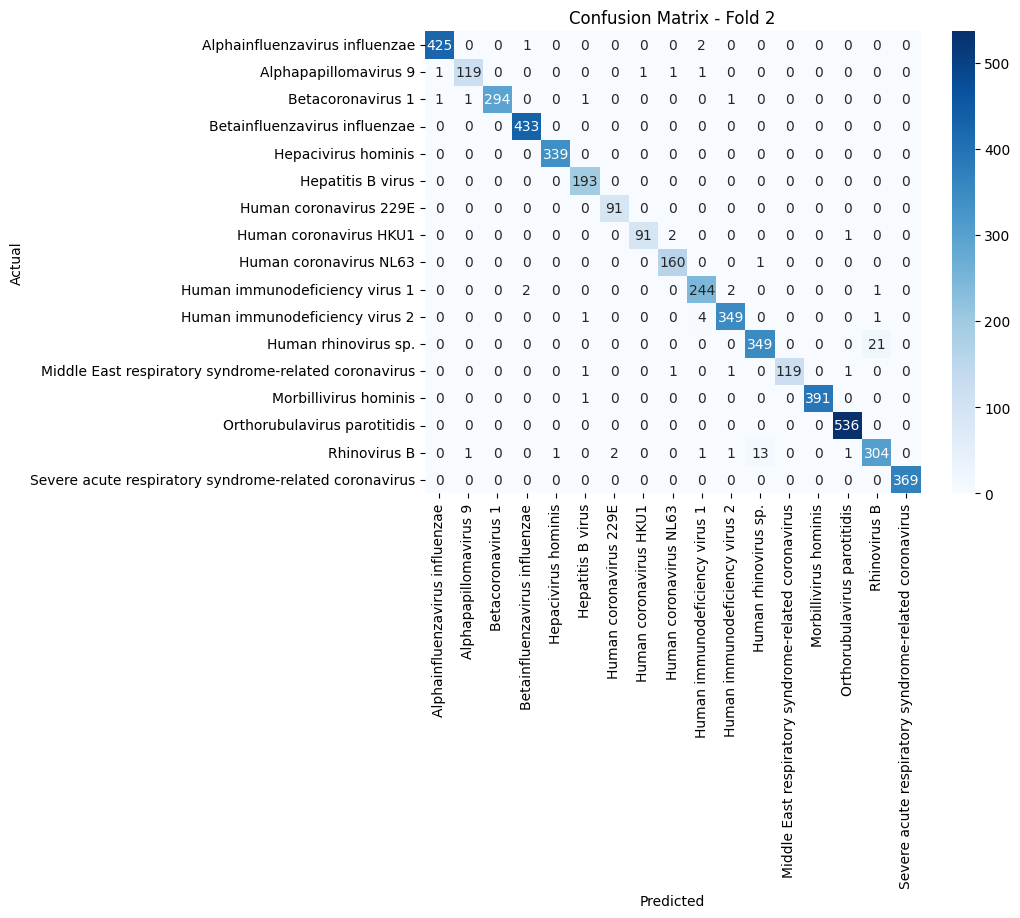

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


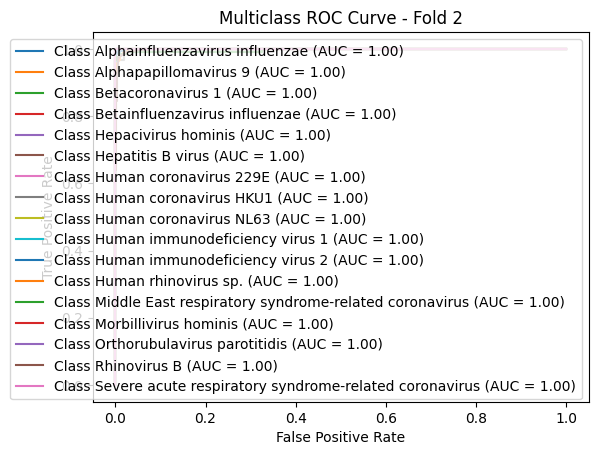

153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


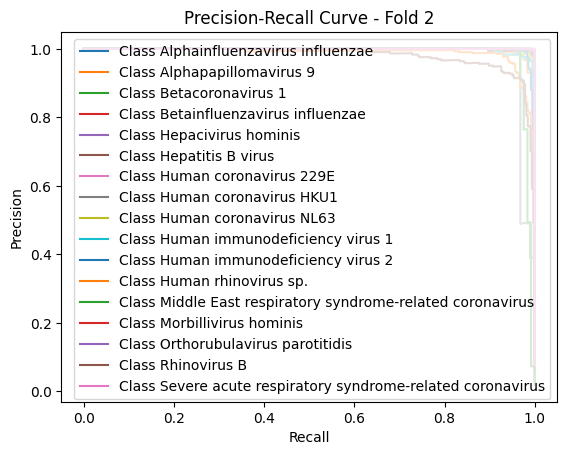

Training Fold 3
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 104ms/step - accuracy: 0.3043 - loss: 2.3836 - val_accuracy: 0.2355 - val_loss: 2.6452 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.7024 - loss: 1.0566 - val_accuracy: 0.7870 - val_loss: 0.9890 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.8003 - loss: 0.6843 - val_accuracy: 0.6835 - val_loss: 0.9962 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.8507 - loss: 0.5124 - val_accuracy: 0.9028 - val_loss: 0.3812 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.8740 - loss: 0.4148 - val_accuracy: 0.8778 - val_loss: 0.4334 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8907 - loss: 0.3653 - val_accuracy: 0.9418 - val_loss: 0.2294 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━

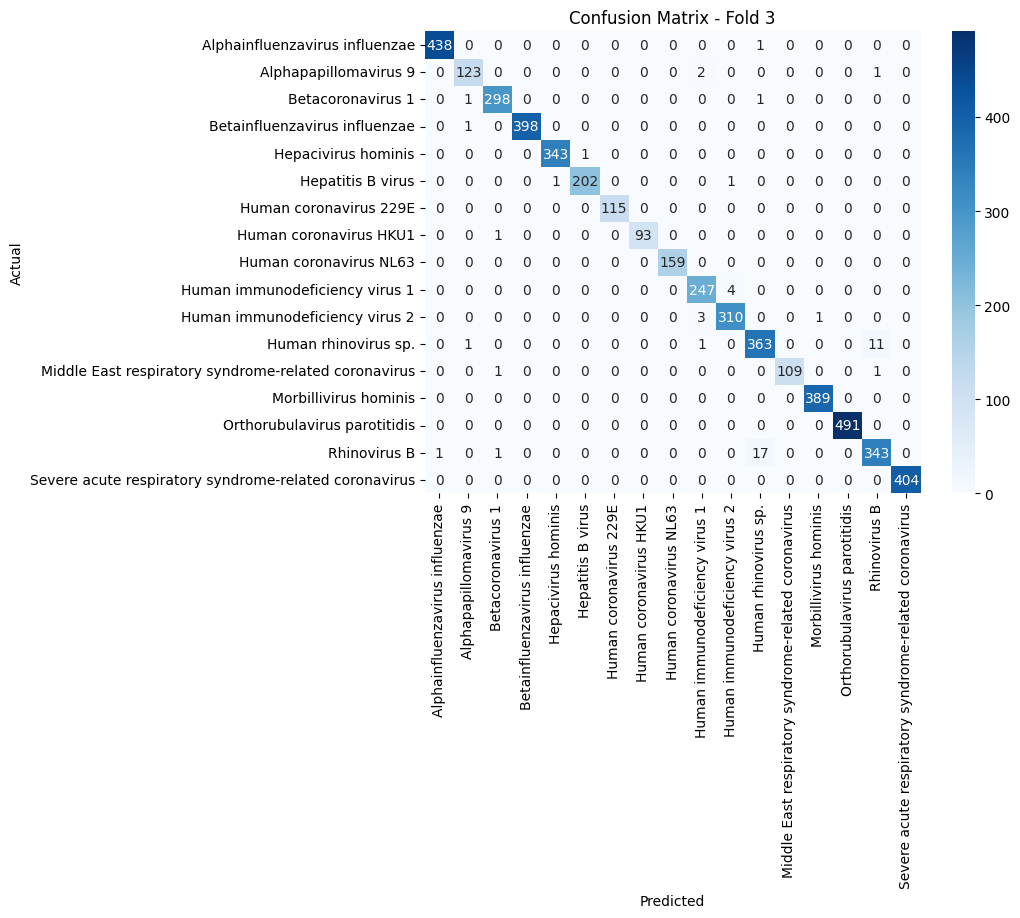

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


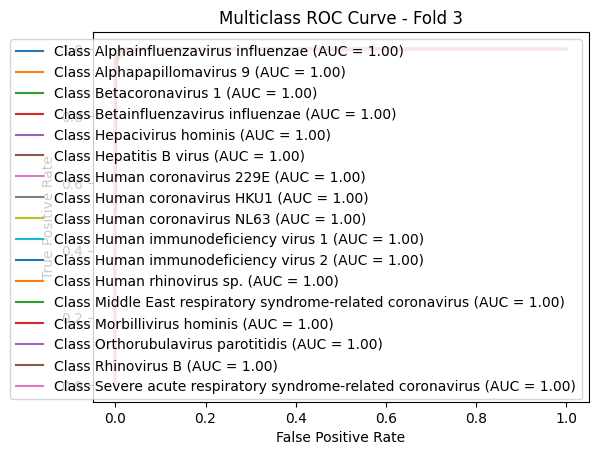

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


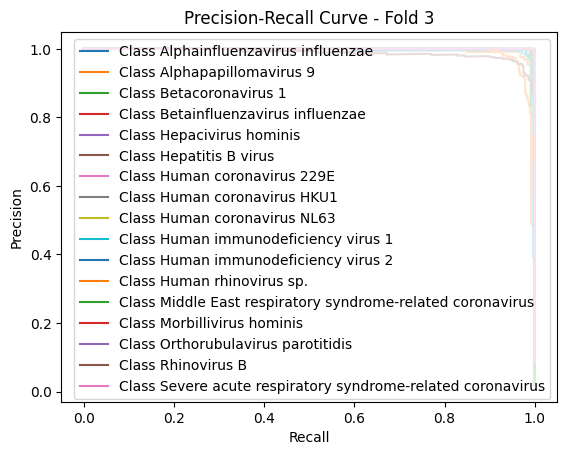

Training Fold 4
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.3035 - loss: 2.3957 - val_accuracy: 0.1868 - val_loss: 2.5213 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - accuracy: 0.7030 - loss: 1.0415 - val_accuracy: 0.4956 - val_loss: 1.7870 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.8043 - loss: 0.6817 - val_accuracy: 0.6871 - val_loss: 1.3174 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.8568 - loss: 0.4977 - val_accuracy: 0.5614 - val_loss: 1.9293 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.8785 - loss: 0.4184 - val_accuracy: 0.9071 - val_loss: 0.3359 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 121ms/step - accuracy: 0.8970 - loss: 0.3497 - val_accuracy: 0.9219 - val_loss: 0.2704 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━

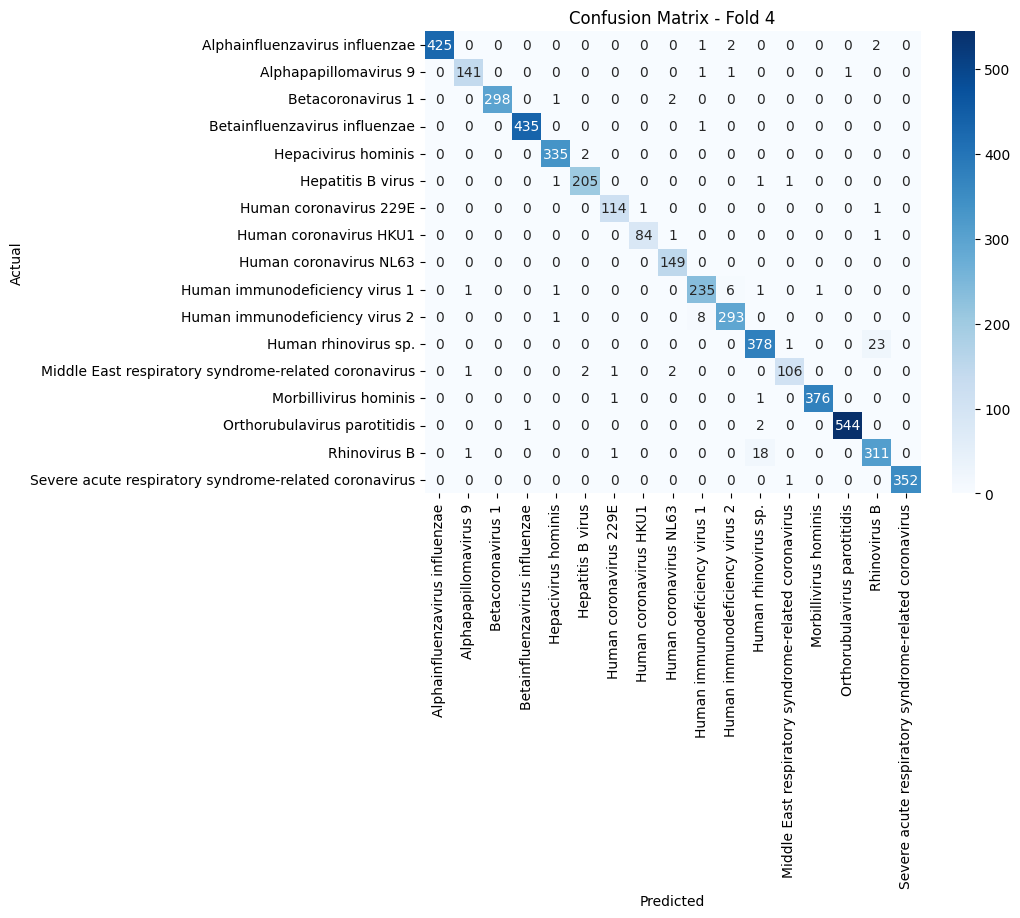

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


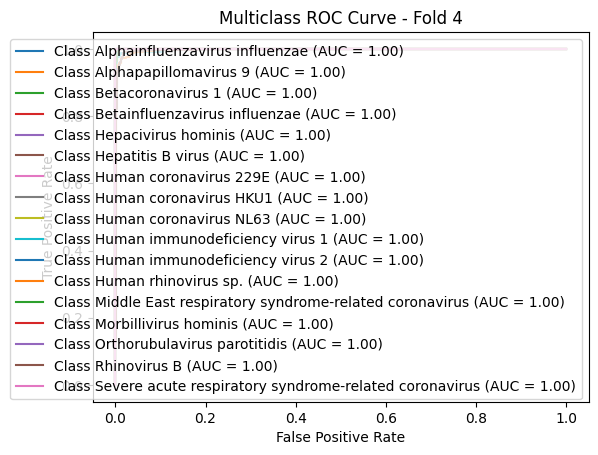

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


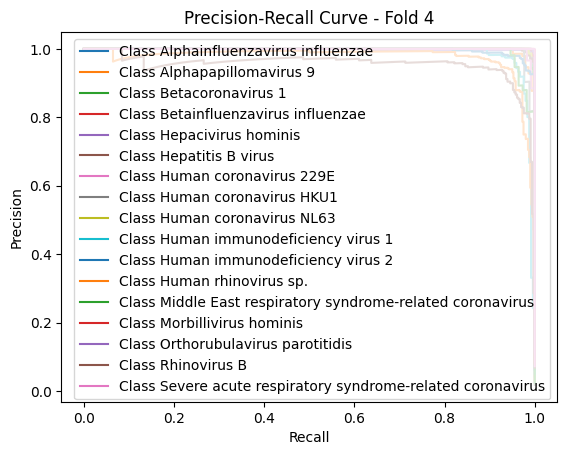

Training Fold 5
Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - accuracy: 0.2809 - loss: 2.4631 - val_accuracy: 0.3164 - val_loss: 2.2811 - learning_rate: 5.0000e-04
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.6666 - loss: 1.1964 - val_accuracy: 0.5891 - val_loss: 1.2517 - learning_rate: 5.0000e-04
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.7705 - loss: 0.7710 - val_accuracy: 0.8052 - val_loss: 0.6612 - learning_rate: 5.0000e-04
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.8260 - loss: 0.5799 - val_accuracy: 0.8464 - val_loss: 0.4777 - learning_rate: 5.0000e-04
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.8650 - loss: 0.4568 - val_accuracy: 0.7486 - val_loss: 0.9296 - learning_rate: 5.0000e-04
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.8824 - loss: 0.3888 - val_accuracy: 0.8823 - val_loss: 0.3443 - learning_rate: 5.0000e-04
Epoch 7/100
305/305 ━━━━

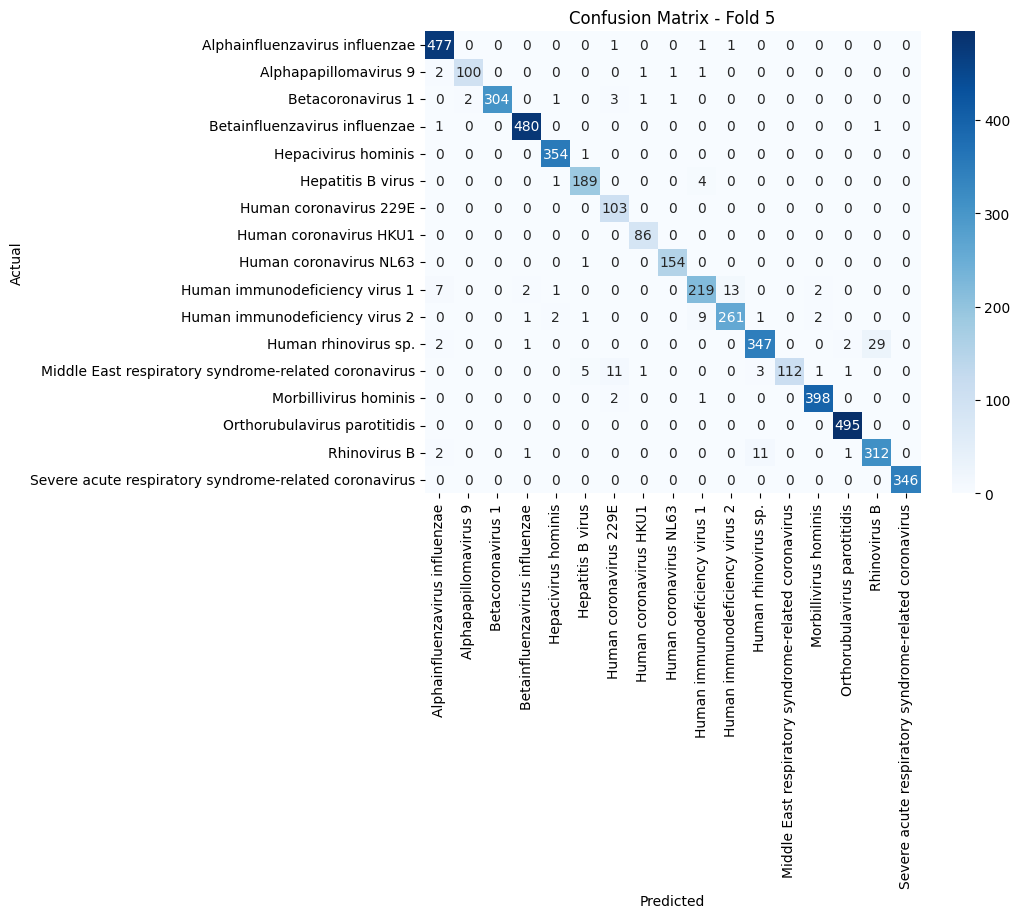

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


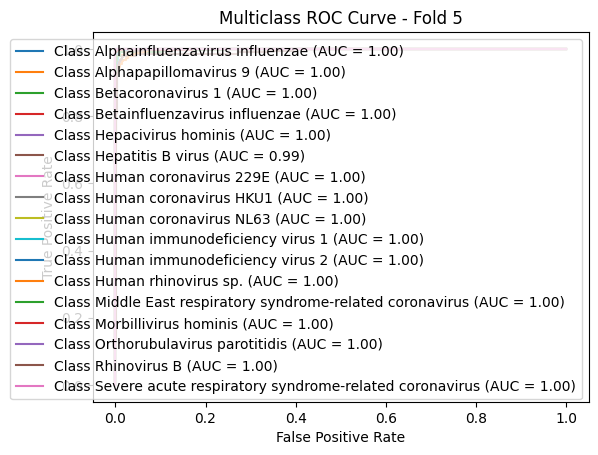

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


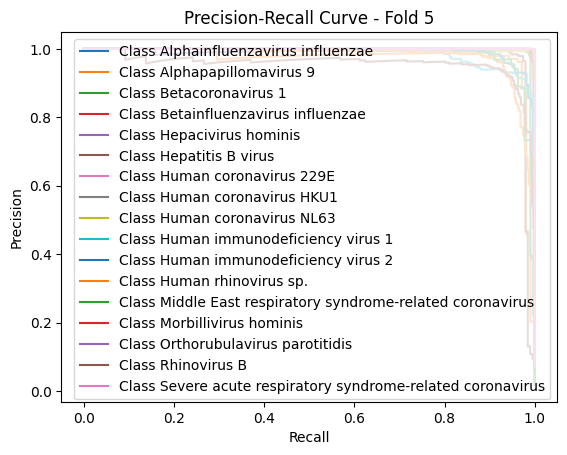

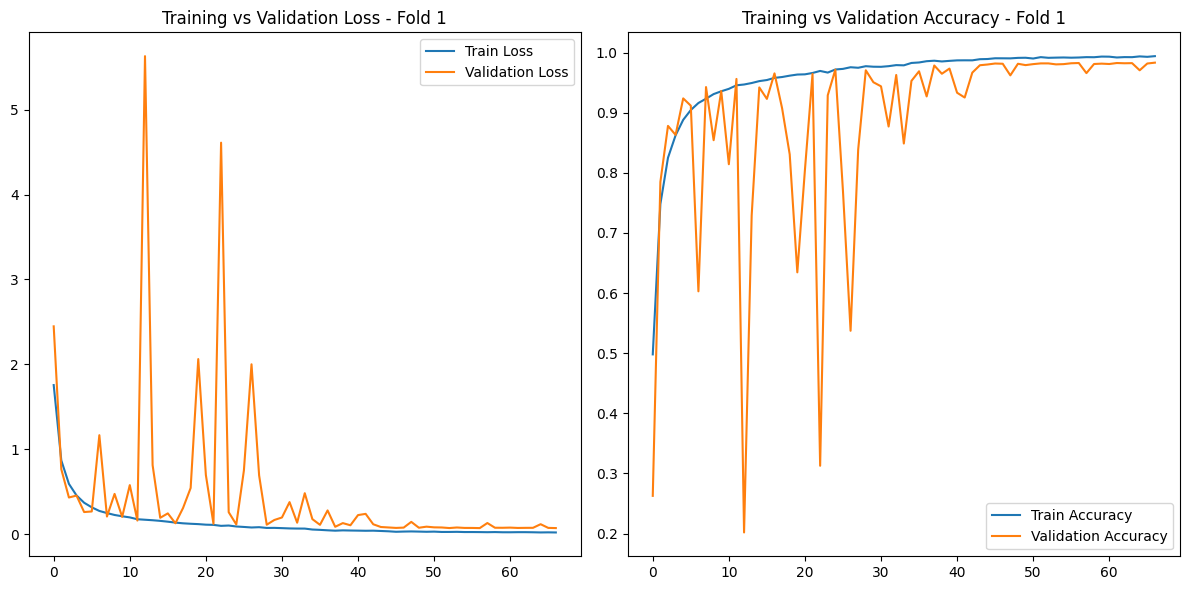

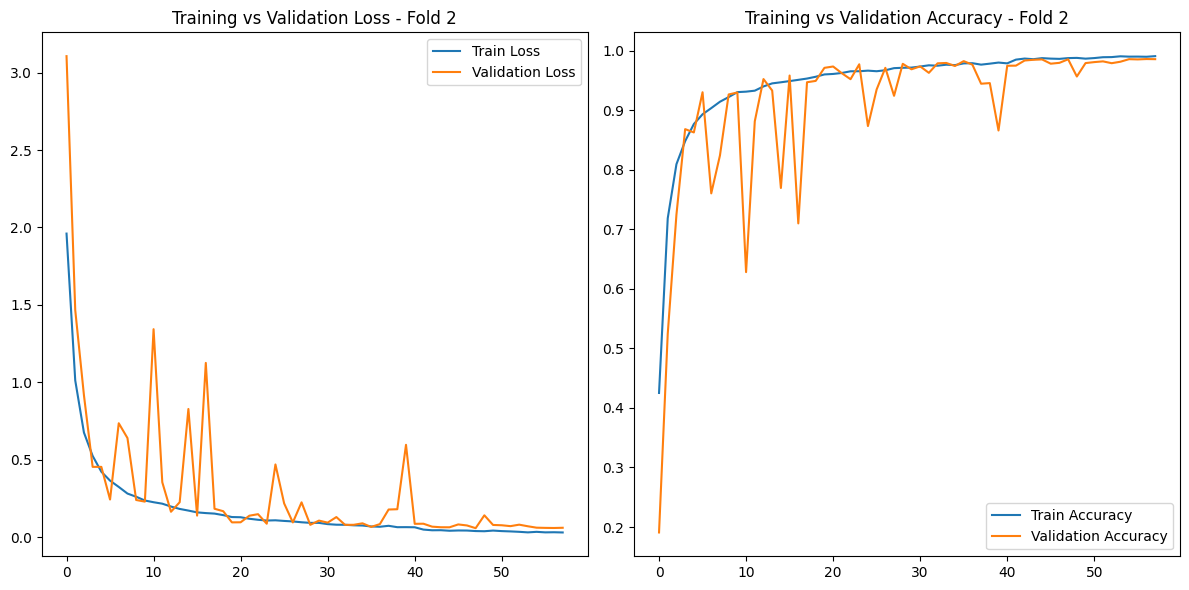

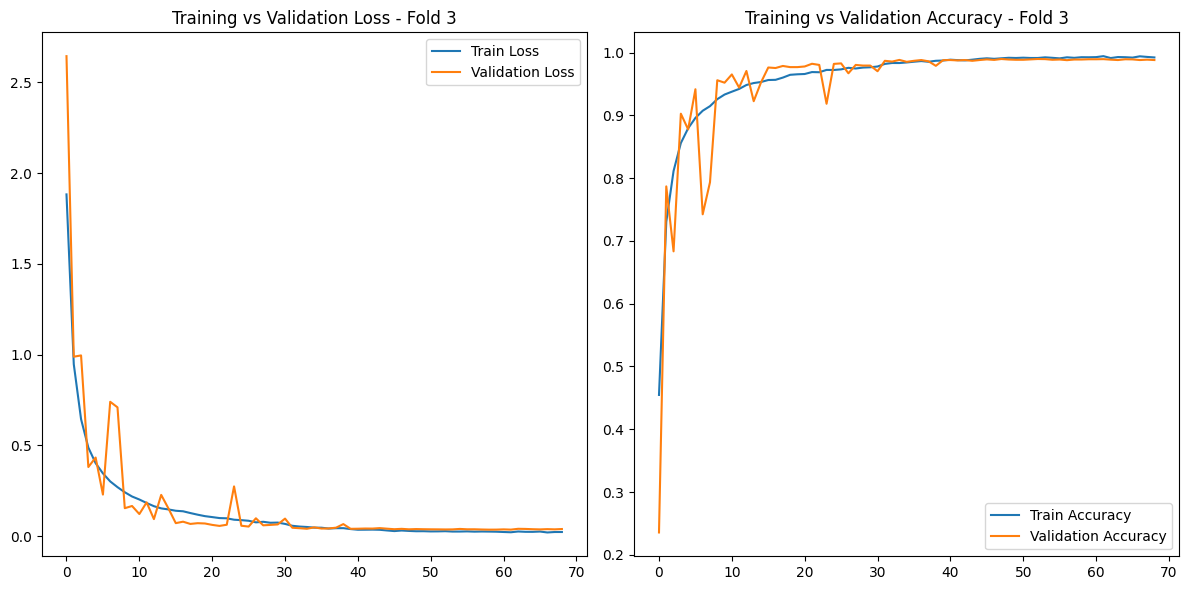

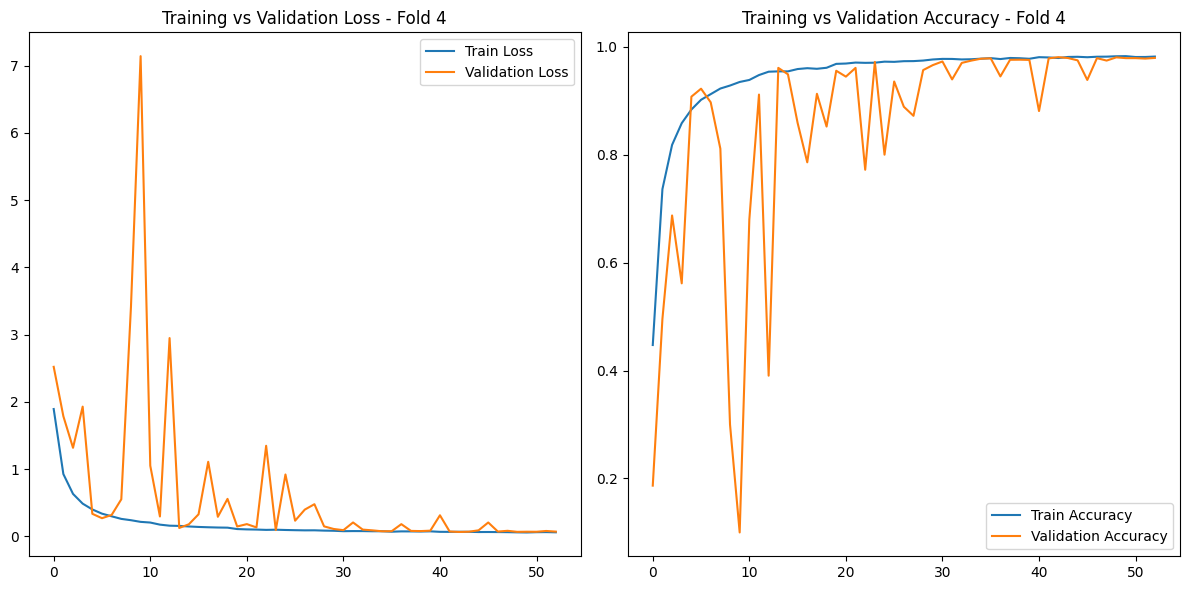

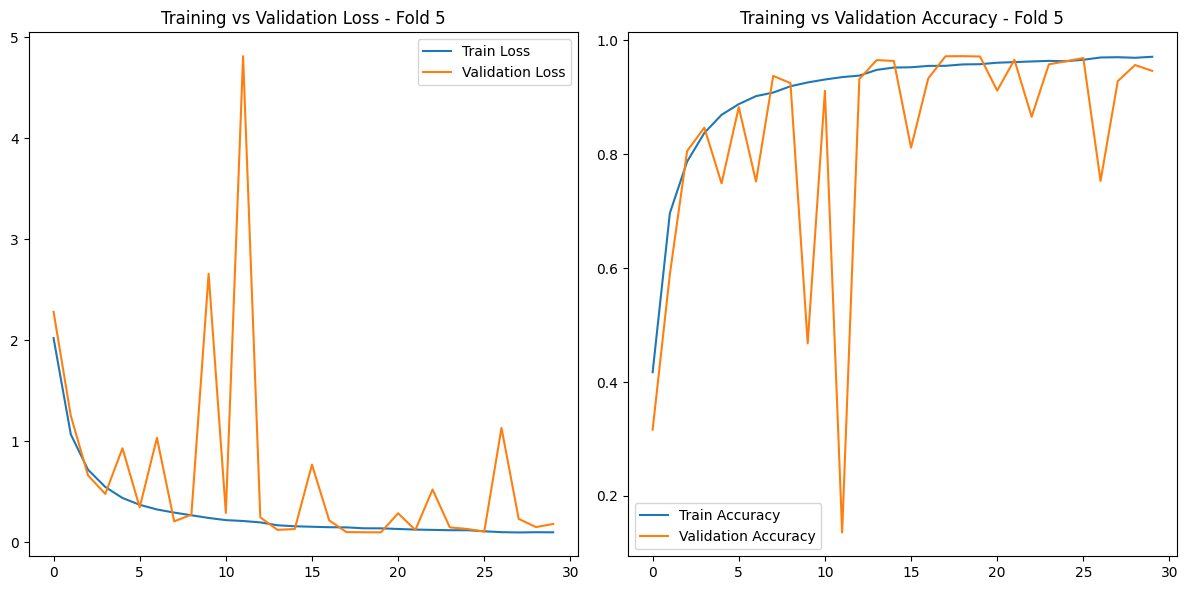

Mean Accuracy: 0.9817 ± 0.0060


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, accuracy_score)
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D, LSTM, 
                                     Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Data Preprocessing
def preprocess_data(df):
    df['sequence'] = df['sequence'].astype(str).str.upper()
    valid_nucleotides = set('ATCG')
    df = df[df['sequence'].apply(lambda x: set(x).issubset(valid_nucleotides))]
    
    features = pd.DataFrame({
        'length': df['sequence'].str.len(),
        'gc_content': df['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x) * 100),
        'a_freq': df['sequence'].apply(lambda x: x.count('A') / len(x)),
        't_freq': df['sequence'].apply(lambda x: x.count('T') / len(x)),
        'g_freq': df['sequence'].apply(lambda x: x.count('G') / len(x)),
        'c_freq': df['sequence'].apply(lambda x: x.count('C') / len(x))
    })
    
    df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['kmers'])
    sequences = tokenizer.texts_to_sequences(df['kmers'])
    X_seq = pad_sequences(sequences, maxlen=500)
    
    scaler = StandardScaler()
    X_num = scaler.fit_transform(features)
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['Species'])
    y_binary = label_binarize(y, classes=np.arange(len(label_encoder.classes_)))
    
    return X_seq, X_num, y, y_binary, tokenizer, scaler, label_encoder

# Model Definition
def build_model(vocab_size, n_features, n_classes):
    seq_input = Input(shape=(500,))
    x1 = Embedding(vocab_size + 1, 64)(seq_input)
    conv1 = Conv1D(32, 3, activation='relu', padding='same')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(16, 3, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = GlobalMaxPooling1D()(conv2)
    lstm = LSTM(32, return_sequences=False)(x1)
    lstm = BatchNormalization()(lstm)
    seq_features = Concatenate()([conv2, lstm])
    seq_features = Dropout(0.2)(seq_features)
    num_input = Input(shape=(n_features,))
    num_features = Dense(16, activation='relu')(num_input)
    num_features = BatchNormalization()(num_features)
    combined = Concatenate()([seq_features, num_features])
    x = Dense(32, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs=[seq_input, num_input], outputs=outputs)

# Training and Evaluation
def train_and_evaluate():
    df = pd.read_csv('momo.csv')  # Update with your dataset path
    X_seq, X_num, y, y_binary, tokenizer, scaler, label_encoder = preprocess_data(df)
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []
    histories = []
    class_names = label_encoder.classes_
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_seq)):
        print(f"Training Fold {fold + 1}")
        X_seq_train, X_seq_val = X_seq[train_idx], X_seq[val_idx]
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        y_train_binary, y_val_binary = y_binary[train_idx], y_binary[val_idx]
        
        model = build_model(len(tokenizer.word_index), X_num.shape[1], len(np.unique(y)))
        model.compile(optimizer=Adam(learning_rate=0.0005),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        history = model.fit(
            [X_seq_train, X_num_train], y_train_binary,
            validation_data=([X_seq_val, X_num_val], y_val_binary),
            epochs=100, batch_size=64, callbacks=callbacks, verbose=1
        )
        histories.append(history.history)
        fold_scores.append(model.evaluate([X_seq_val, X_num_val], y_val_binary, verbose=1)[1])
        
        # Confusion Matrix
        y_pred = np.argmax(model.predict([X_seq_val, X_num_val]), axis=1)
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Multiclass ROC Curve
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_val_binary[:, i], model.predict([X_seq_val, X_num_val])[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve - Fold {fold + 1}')
        plt.legend()
        plt.show()

        # Precision-Recall Curve for Each Class
        for i in range(len(class_names)):
            precision, recall, _ = precision_recall_curve(y_val_binary[:, i], model.predict([X_seq_val, X_num_val])[:, i])
            plt.plot(recall, precision, label=f'Class {class_names[i]}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Fold {fold + 1}')
        plt.legend()
        plt.show()

        tf.keras.backend.clear_session()
    
    # Training Curves
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'Training vs Validation Loss - Fold {i + 1}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Training vs Validation Accuracy - Fold {i + 1}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    print(f"Mean Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

if __name__ == "__main__":
    train_and_evaluate()


In [12]:
# Rerun preprocessing steps
df = pd.read_csv('momo.csv')  # Ensure this is the correct path to your dataset
X_seq, X_num, y, y_binary, tokenizer, scaler, label_encoder = preprocess_data(df)

# Split the data
from sklearn.model_selection import train_test_split
X_seq_train, X_seq_val, X_num_train, X_num_val, y_train, y_val, y_train_binary, y_val_binary = train_test_split(
    X_seq, X_num, y, y_binary, test_size=0.2, random_state=42
)

# Rebuild and compile the model
model = build_model(len(tokenizer.word_index), X_num.shape[1], len(np.unique(y)))
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit([X_seq_train, X_num_train], y_train_binary, 
          validation_data=([X_seq_val, X_num_val], y_val_binary),
          epochs=50, batch_size=64, verbose=1)

# Plot Multiclass ROC Curve
plt.figure(figsize=(10, 6))
n_classes = y_val_binary.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binary[:, i], model.predict([X_seq_val, X_num_val])[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

# Print class names
print("Class names:", label_encoder.classes_)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_val_binary[:, i], model.predict([X_seq_val, X_num_val])[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_1820\2371012983.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kmers'] = df['sequence'].apply(lambda x: ' '.join([x[i:i+3] for i in range(len(x)-2)]))


ValueError: not enough values to unpack (expected 7, got 5)